# Machine Learning Model

## Imports

In [698]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import r2_score, max_error, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, KFold

from sklearn.feature_selection import SelectKBest, f_classif

from keras import models, layers

## Tratamento inicial

Observação dos dados

In [699]:
df = pd.read_pickle('../datasets/processed.pkl')
df.drop(columns = 'segundos_depois_meia_noite', inplace = True)
df.sample(5)

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
20883,2018-06-08 13:00:00,5.87,0.00,24.91,0.0,100.00,22.94,Dia da Semana,Segunda-feira,Carga media
11032,2018-04-25 22:15:00,4.00,1.44,14.18,0.0,94.09,27.15,Dia da Semana,Quarta-feira,Carga media
13938,2018-05-26 04:45:00,3.13,5.58,0.00,0.0,48.92,100.00,Final de Semana,Sabado,Carga leve
26334,2018-02-10 07:45:00,3.17,5.29,0.00,0.0,51.40,100.00,Dia da Semana,Terca-feira,Carga leve
672,2018-08-01 00:15:00,3.78,5.15,0.00,0.0,59.17,100.00,Dia da Semana,Segunda-feira,Carga leve


Após discussões obtidas durante as sessões de dúvidas, foi decidido que o tratamento inicial dos dados seria feito da seguinte forma:
- Agrupamento dos dados por dia, onde os numericos seriam as médias e os categóricos seriam a moda

In [700]:
df = df.groupby(df['data'].dt.date).agg({
    'consumo_energia': 'mean',
    'corrente_atrasada': 'mean',
    'corrente_principal': 'mean',
    'co2': 'mean',
    'potencia_atrasado': 'mean',
    'potencia_principal': 'mean',
    'estado_semana': lambda x: x.mode()[0],
    'dia_semana': lambda x: x.mode()[0],
    'tipo_carga': lambda x: x.mode()[0]
}).reset_index()

df.data = pd.to_datetime(df.data)
for item in df.select_dtypes('object').columns:
    df[item] = df[item].astype('category')
    
df.estado_semana = LabelEncoder().fit_transform(df.estado_semana)

In [701]:
df.head()

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
0,2018-01-01,3.665208,1.735625,9.885000,0.000000,85.299375,57.076146,0,Segunda-feira,Carga leve
1,2018-01-02,63.694375,29.284792,1.123854,0.028333,86.513646,97.887083,0,Quinta-feira,Carga leve
2,2018-01-03,17.442083,5.274896,6.329583,0.007085,84.145729,82.801563,0,Quinta-feira,Carga leve
3,2018-01-04,3.018958,1.737604,9.319479,0.000000,81.751667,55.545729,1,Domingo,Carga leve
4,2018-01-05,3.110937,1.949792,9.087813,0.000000,80.501042,56.299167,0,Terca-feira,Carga leve


In [702]:
aux = df.copy()
for item in aux.select_dtypes('category').columns:
    aux[item] = LabelEncoder().fit_transform(aux[item])

aux.corr(numeric_only=True).abs()

,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
consumo_energia,1.000000,0.937050,0.816783,0.990505,0.024184,0.857353,0.641788,0.373589,NaN
corrente_atrasada,0.937050,1.000000,0.845748,0.932578,0.223848,0.839868,0.702574,0.386223,NaN
corrente_principal,0.816783,0.845748,1.000000,0.821324,0.322724,0.947876,0.687508,0.418245,NaN
co2,0.990505,0.932578,0.821324,1.000000,0.010454,0.856806,0.637512,0.364504,NaN
potencia_atrasado,0.024184,0.223848,0.322724,0.010454,1.000000,0.174759,0.185159,0.098755,NaN
potencia_principal,0.857353,0.839868,0.947876,0.856806,0.174759,1.000000,0.687059,0.435202,NaN
estado_semana,0.641788,0.702574,0.687508,0.637512,0.185159,0.687059,1.000000,0.474785,NaN
dia_semana,0.373589,0.386223,0.418245,0.364504,0.098755,0.435202,0.474785,1.000000,NaN
tipo_carga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [703]:
del aux
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                365 non-null    datetime64[ns]
 1   consumo_energia     365 non-null    float64       
 2   corrente_atrasada   365 non-null    float64       
 3   corrente_principal  365 non-null    float64       
 4   co2                 365 non-null    float32       
 5   potencia_atrasado   365 non-null    float64       
 6   potencia_principal  365 non-null    float64       
 7   estado_semana       365 non-null    int64         
 8   dia_semana          365 non-null    category      
 9   tipo_carga          365 non-null    category      
dtypes: category(2), datetime64[ns](1), float32(1), float64(5), int64(1)
memory usage: 22.7 KB


## Testes e experimentações com os dados e modelos

Temos algumas alternativas para selecionar os dados que serão utilizados no modelo:
- Utilizar todos os dados disponíveis
- Remover os dados com correlação alta com a variável alvo
- Remover os dados com correlação alta entre si

In [704]:
features = df.drop(columns = 'consumo_energia')
target = df.consumo_energia

Foram realizados alguns testes relacionados a essas alternativas, e os resultados foram os seguintes:

- Foi feito alguns testes com todos os dados disponíveis, porém os resultados não foram satisfatórios;
- A partir disso, foi feito um teste removendo os dados com correlação alta com a variável alvo, e os resultados foram melhores, porém o modelo overfitta facilmente;
- Por fim, foi feito um teste removendo os dados com correlação alta entre si, e os resultados foram melhores ainda. Porém, o modelo ainda overfitta facilmente.
- Por fim foi realizado testes removendo o dado com maior correlação e os dados com correlação alta entre si, e os resultados foram melhores ainda. Com a possibilidade de remover mais dados com correlação baixa com a variável alvo (será visto mais abaixo).

In [705]:
features.drop(columns = ['co2', 'potencia_principal'], inplace = True)

Para treino e teste foi utilizados respectivamente os 11 meses do ano registrado e o mês de dezembro.

In [706]:
test = [12]
idx_train = features[~features.data.dt.month.isin(test)].drop(columns = ['data']).index
idx_test = features[features.data.dt.month.isin(test)].drop(columns = ['data']).index
del test

In [707]:
features.drop(columns = ['data'], inplace = True)

In [708]:
x_train, x_test, y_train, y_test = features.iloc[idx_train], features.iloc[idx_test], target.iloc[idx_train], target.iloc[idx_test]

O pipeline utilizado foi o seguinte:

In [709]:
def create_model(features: pd.DataFrame, model, scaler=True) -> Pipeline:
    if scaler:
        numerical = features.select_dtypes(include='number').columns.to_list()
        num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        
    categorical = features.select_dtypes(include='category').columns.to_list()
    cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    
    if scaler: transformers = [('num', num_transformer, numerical), ('cat', cat_transformer, categorical)]
    else: transformers = [('cat', cat_transformer, categorical)]
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("model", model)
    ])

Para análise das features foi utilizado o método de correlação de Pearson, e foi observado como os treinos e testes se comportam ao utilizar as features com maior correlação com a variável alvo, com o objetivo de encontrar um ponto de equilíbrio entre a quantidade de features e a acurácia do modelo.

In [710]:
def curve_of_feature(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, var: list, model) -> tuple:
    scaler = StandardScaler()
    score = { 'Error_train': [], 'Error_test': [] }
    
    higher_in_train, higher_in_test = [0, 0], [0, 0]
    for i in range(1, features.shape[1]+1):
        x_train_temp, x_test_temp = x_train[var[:i]], x_test[var[:i]]
        
        categorical = x_train_temp.select_dtypes(include='category').columns.to_list()
        x_train_temp = pd.get_dummies(x_train_temp, columns=categorical, drop_first=True)
        x_test_temp = pd.get_dummies(x_test_temp, columns=categorical, drop_first=True)
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        new_model = model
        new_model.fit(x_train_temp, y_train)
        y_pred_train = new_model.predict(x_train_temp)
        y_pred_test = new_model.predict(x_test_temp)
        
        error_train, error_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
        
        if error_train > higher_in_train[0]: higher_in_train = [error_train, i]
        if error_test > higher_in_test[0]: higher_in_test = [error_test, i]
        
        score['Error_train'].append(error_train); score['Error_test'].append(error_test)
    
    return pd.DataFrame(score), higher_in_train, higher_in_test

Utilizamos alguns gráficos para melhor visualização dos resultados:

In [711]:
def plot_curve_of_features(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, corr_in_order, model_list):
    fig = plt.figure(figsize=(16, 8))
    i = 0
    for name, model in model_list.items():
        curve, higher_in_train, higher_in_test = curve_of_feature(x_train, x_test, y_train, y_test, corr_in_order, model)
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_title(name)
        x = np.arange(1, curve.shape[0]+1)
        sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
        ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
        sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
        ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
        ax.set_xticks(x)
        ax.set_xlabel('Number of features with highest correlation')
        ax.legend()
        i+=1
    fig.tight_layout()

In [712]:
features_test = features.copy()
for item in features_test.select_dtypes('category').columns:
    features_test[item] = LabelEncoder().fit_transform(features_test[item])

corr_in_order = pd.concat([features_test, target], axis = 1).corr(numeric_only=True).abs().consumo_energia.sort_values(ascending=False)[1:].index.tolist()

A partir dos dados tratados, foram realizados testes com os seguintes modelos:
- Regressão Linear
- KNN
- Decision Tree
- Random Forest

Em todos os testes podemos observar que o modelo de Decision Tree tende a overfittar mais facilmente.

E a conclusão foi a seguinte:
- Ao utilizar as 5 features com maior correlação com a variável alvo, o modelo que obteve bons resultados.

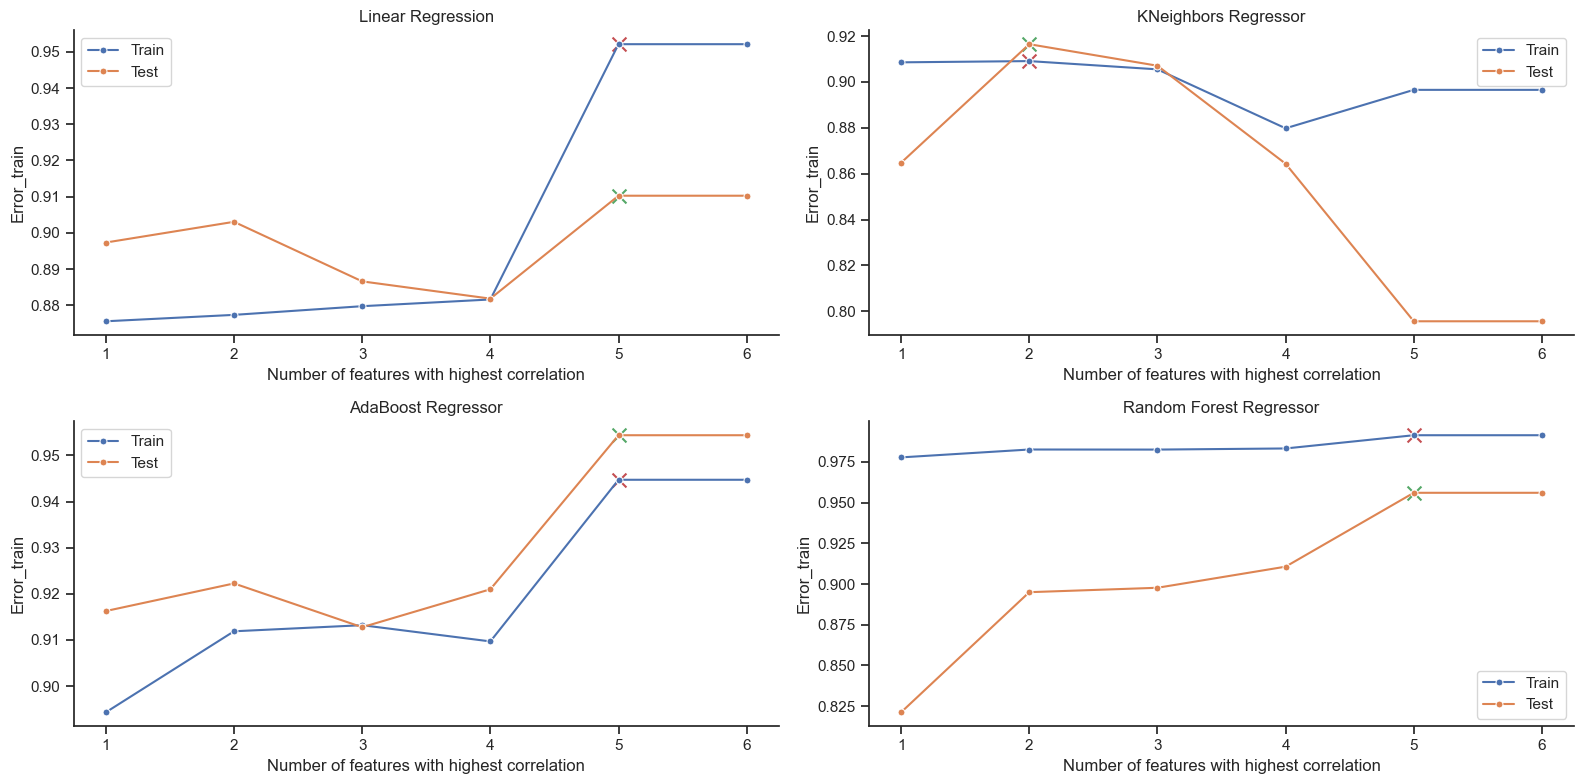

In [713]:
model_list = {
    'Linear Regression': LinearRegression(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=777),
    'Random Forest Regressor': RandomForestRegressor(random_state=777, n_jobs=-1),
}

plot_curve_of_features(x_train, x_test, y_train, y_test, corr_in_order, model_list)
plt.show()

In [714]:
def create_scores(model_list: dict, train_x: pd.DataFrame, train_y: pd.Series, test_x: pd.DataFrame, test_y: pd.Series) -> pd.DataFrame:
    scores = {
        'Algorithm': [],
        'Type': [],
        'R2': [],
        'Max Error': [],
        'Mean Absolute Error': [],
        'Mean Squared Error': []
    }
    
    for algorithm, the_model in model_list.items():
        for item in ['Train', 'Test']:
            model = the_model
            model.fit(train_x, train_y)
            
            if item == 'Train':
                pred_y = model.predict(train_x)
                scores['Type'].append('Train')
                target = train_y
            else:
                pred_y = model.predict(test_x)
                scores['Type'].append('Test')
                target = test_y
                
            scores['Algorithm'].append(algorithm)
            scores['R2'].append( round( r2_score(target, pred_y), 2) )
            scores['Max Error'].append( round( max_error(target, pred_y), 2) )
            scores['Mean Absolute Error'].append( round( mae(target, pred_y), 2) )
            scores['Mean Squared Error'].append( round( mse(target, pred_y), 2) )

    return pd.DataFrame(scores)

In [715]:
def create_learning_curves(model_list: dict, features: pd.DataFrame, target: pd.Series, n_row = 2, n_col = 2, cv = 5, scoring = 'r2') -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, (algorithm, model_) in enumerate(model_list.items()):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        plt.title(f"{algorithm}", fontsize='large', fontweight='bold')
        plt.grid(visible=True, color='black', linewidth=.25)
        plt.xlabel("Number of Samples")
        LearningCurveDisplay.from_estimator(model_, features, target, score_type='both', ax=ax, cv=cv, scoring=scoring, n_jobs=-1, random_state=777)
    fig.tight_layout()

In [716]:
def create_plot(results: pd.DataFrame, n_rows = 2, n_cols = 2, rot=45) -> None:
    fig = plt.figure(figsize=(16, 10))
    for i, title in enumerate(results.columns[2:]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.barplot(data=results, x='Algorithm', y=title, hue='Type', palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
        ax.grid(visible=True, color='black', linewidth=.25)
    fig.tight_layout()

In [717]:
def cross_validation(model, model_name: str, features: pd.DataFrame, target: pd.Series, cv=5) -> pd.DataFrame:
    kf = KFold(n_splits=cv)
    scores = {
        'model': model_name,
        'train_score': [],
        'test_score': [],
        'train_mae': [],
        'test_mae': [],
    }

    for train_index, test_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        test_x, test_y = features.iloc[test_index], target.iloc[test_index]
        
        new_model = model
        new_model.fit(train_x, train_y)

        pred_train_y = new_model.predict(train_x)
        pred_test_y = new_model.predict(test_x)

        scores['train_score'].append( r2_score(train_y, pred_train_y) )
        scores['test_score'].append( r2_score(test_y, pred_test_y) )
        scores['train_mae'].append( mae(train_y, pred_train_y) )
        scores['test_mae'].append( mae(test_y, pred_test_y) )
    
    return pd.DataFrame(scores)

In [718]:
def plot_validation_curve(results: list, title: list, type: str, n_row=2, n_col=2) -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, item in enumerate(results):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        x = np.arange(item.shape[0])
        
        if type == 'r2':
            metric_train = 'train_score'
            metric_test = 'test_score'
        else:
            metric_train = 'train_mae'
            metric_test = 'test_mae'
        
        if item[metric_train].max() < item[metric_test].max(): max = item[metric_test].max()
        else: max = item[metric_train].max()
        if item[metric_train].min() > item[metric_test].min(): min = item[metric_test].min()
        else: min = item[metric_train].min()
            
        min = round(min, 1)
        max = round(max, 1)
        
        sns.lineplot(data=item, x=x, y=metric_train, label='Training Scores', marker= 'o', markersize=5, ax=ax)
        sns.lineplot(data=item, x=x, y=metric_test, label='Testing Scores', marker= 'o', markersize=5, ax=ax)

        if type == 'r2':
            ax.set(ylabel='R2 Score')
        else:
            ax.set(ylabel='MAE Score')
        ax.grid(visible=True, color='black', linewidth=.5)
        ax.set_title(title[i])
        ax.set_ylim(min-0.1, max+0.1)
    fig.tight_layout()

In [719]:
features = features[corr_in_order[:5]]
x_train, x_test = features.iloc[idx_train], features.iloc[idx_test]

# Testes de modelos com dados tratados e features selecionadas

In [720]:
model_list = {
    'Linear Regression': create_model(features, LinearRegression()),
    'KNeighbors Regressor': create_model(features, KNeighborsRegressor()),
    'AdaBoost Regressor': create_model(features, AdaBoostRegressor(random_state=777)),
    'Random Forest Regressor': create_model(features, RandomForestRegressor(random_state=777, n_jobs=-1)),
}

In [721]:
scores = create_scores(model_list, x_train, y_train, x_test, y_test)

Ao utilizar a cruzada para observar a curva de treino e teste, podemos observar que o modelo de Decision Tree tende a overfittar mais facilmente.

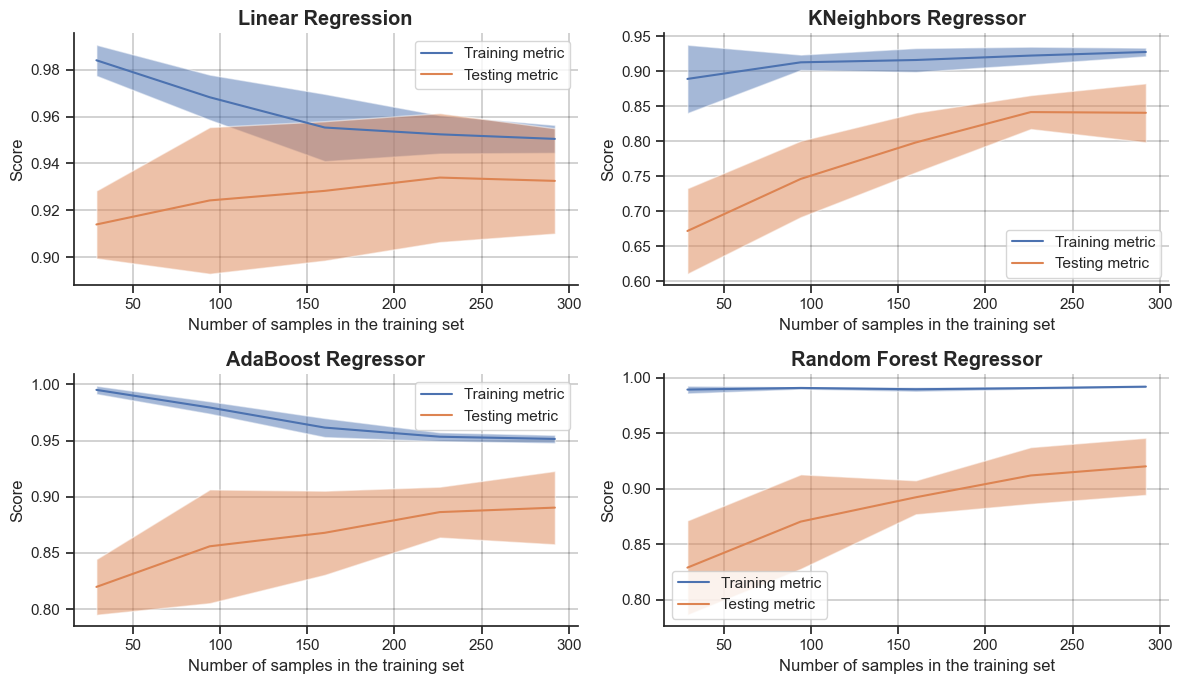

In [722]:
create_learning_curves(model_list, features, target)
plt.show()

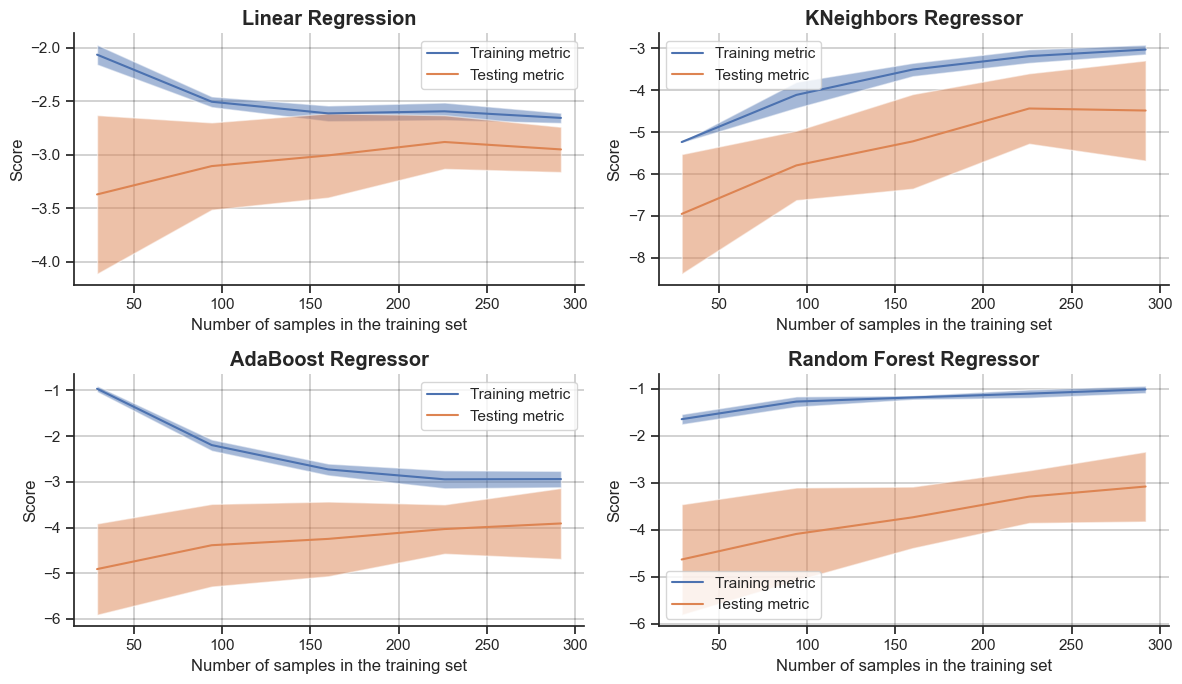

In [723]:
create_learning_curves(model_list, features, target, scoring='neg_mean_absolute_error')
plt.show()

Um comparativo dentre os modelos utilizados:

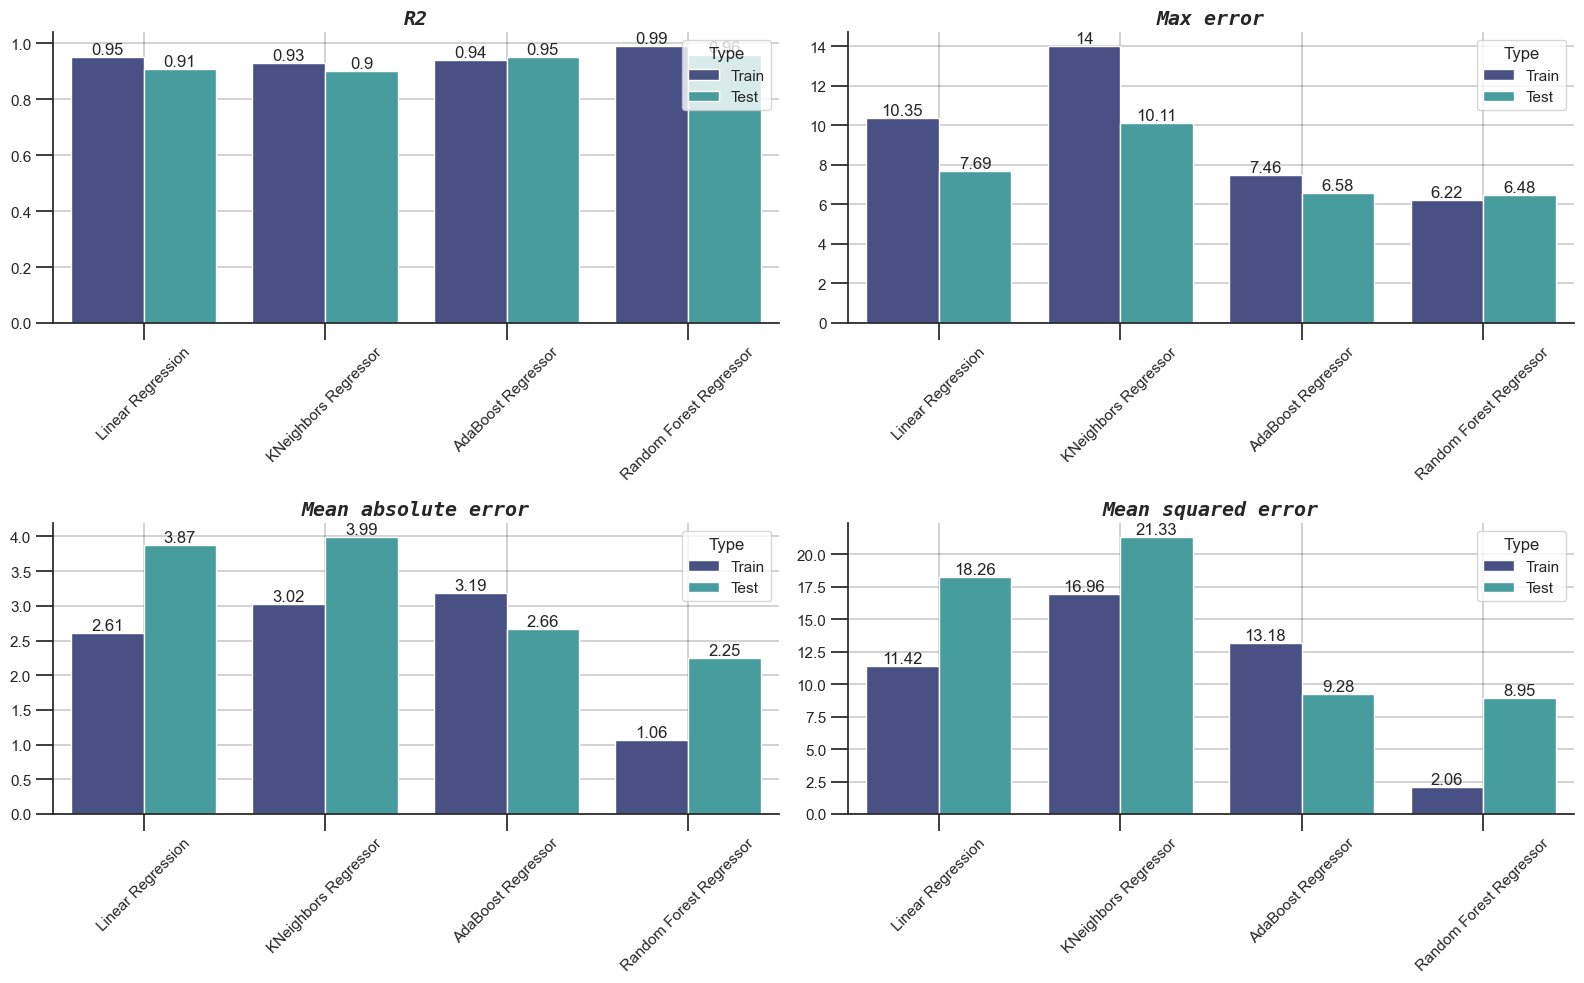

In [724]:
create_plot(scores)
plt.show()

In [725]:
model_results = [cross_validation(model, model_name, features, target, cv=10) for model_name, model in model_list.items()]

Agora vamos observar mais detalhadamente como o modelo se comporta com uma validação cruzada com 10 folds, utilizando:
- R2 Score
- Mean Absolute Error

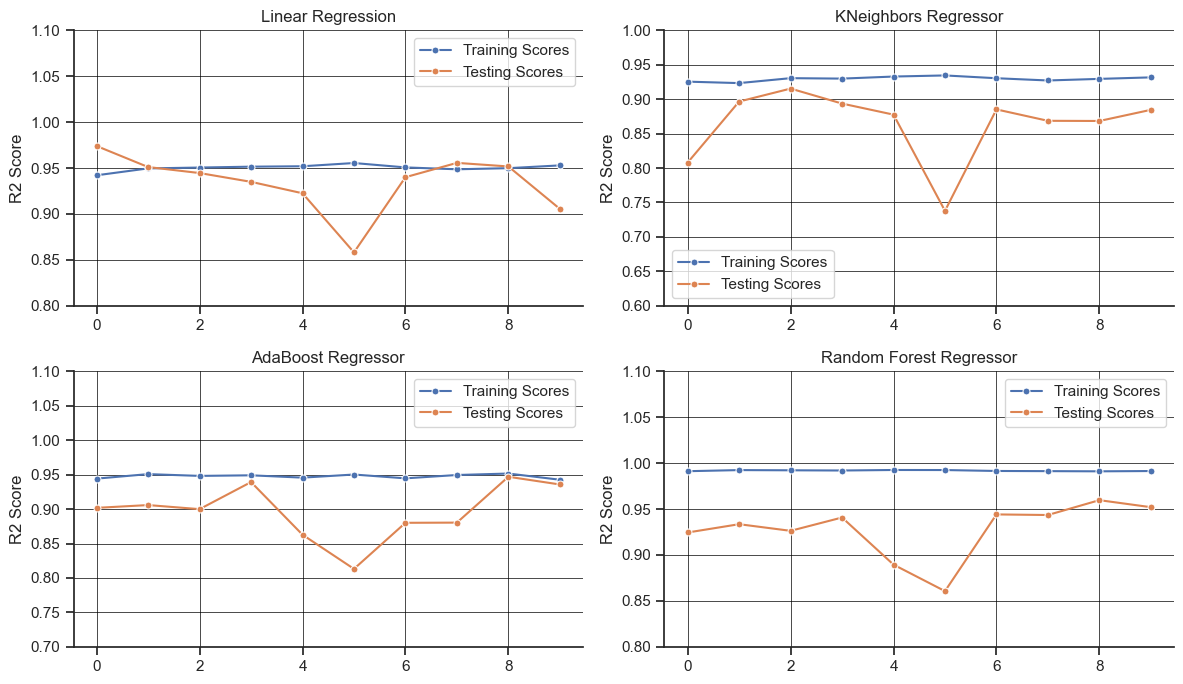

In [726]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

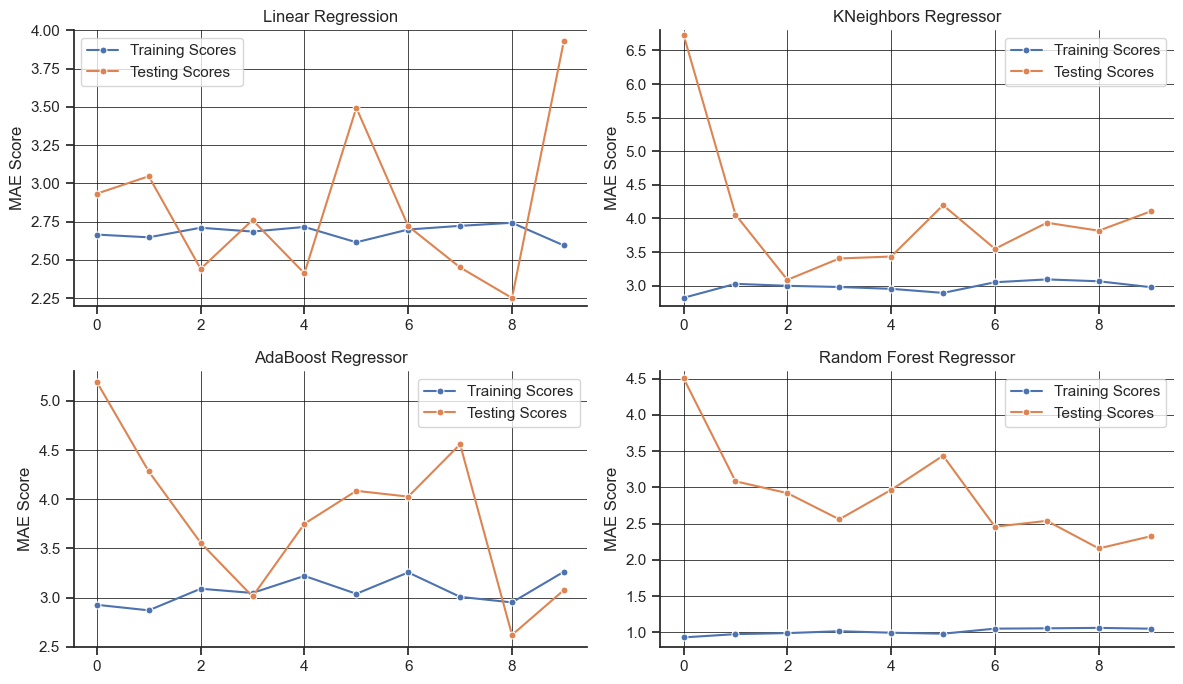

In [727]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

## Tunagem de hiperparâmetros

In [728]:
features_grid = features.copy()

numerical = features_grid.select_dtypes(include='number').columns
categorical = features_grid.select_dtypes(include='category').columns

features_grid[numerical] = StandardScaler().fit_transform(features_grid[numerical])
features_grid = pd.get_dummies(features_grid, columns=categorical, drop_first=True)

In [729]:
# param_grid = {
#     'copy_X': [True, False],
#     'fit_intercept': [True, False],
#     'positive': [True, False]
# }

# grid = GridSearchCV(LinearRegression(), param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

In [730]:
# param_grid = {
#     'n_neighbors': np.arange(1, 9, 2),
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'leaf_size': np.arange(10, 51, 10),
# }

# grid = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

In [731]:
# param_grid = {
#     'max_depth': np.arange(1, 10),
#     'min_samples_split': np.arange(2, 10),
#     'min_samples_leaf': np.arange(1, 10),
#     'max_features': ['sqrt', 'log2'],
#     'n_estimators': np.arange(100, 600, 100)
# }

# grid = GridSearchCV(RandomForestRegressor(random_state=777), param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

# Testes de modelos tunados

In [732]:
model_list = {
    'Linear Regression': create_model(features, LinearRegression(copy_X=True, fit_intercept=False, positive=False)),
    'KNeighbors Regressor': create_model(features, KNeighborsRegressor(algorithm='brute', leaf_size=10, n_neighbors=3, weights='distance')),
#     'Random Forest Regressor': create_model(features, RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=777, n_jobs=-1)),
}

In [733]:
# create_learning_curves(model_list, features, target)
# plt.show()

In [734]:
# create_learning_curves(model_list, features, target, scoring='neg_mean_absolute_error')
# plt.show()

In [735]:
# scores = create_scores(model_list, x_train, y_train, x_test, y_test)
# create_plot(scores)
# plt.show()

In [736]:
# model_results = [cross_validation(model, model_name, features, target, cv=10) for model_name, model in model_list.items()]

In [737]:
# plot_validation_curve(model_results, list(model_list.keys()), 'r2')
# plt.show()

In [738]:
# plot_validation_curve(model_results, list(model_list.keys()), 'mae')
# plt.show()

# Redes neurais

In [739]:
# features_neural = df.drop(columns='data').copy()
# features_neural = pd.get_dummies(features_neural, drop_first=True)

# x_train, x_test, y_train, y_test = features_neural.iloc[idx_train], features_neural.iloc[idx_test], target.iloc[idx_train], target.iloc[idx_test]

# scaler = StandardScaler()

# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

In [740]:
# def create_network(len_input: int) -> models.Sequential:
#     network = models.Sequential()
#     network.add(layers.Dense(30, input_shape=(len_input, ), activation='relu'))
#     network.add(layers.Dense(30))
#     network.add(layers.Dense(1))
#     network.compile(loss="mae", optimizer='Adam', metrics=["mse"])
#     return network

# model = create_network(features_neural.shape[1])

# history = model.fit(x_train_scaled, y_train, epochs=31, verbose=1, batch_size=10, 
#                     validation_data=(x_test_scaled, y_test), shuffle=True)
# pred_y = model.predict(x_test_scaled)

# print(f'Algorithm: MLP')
# print(f'R2 score: {r2_score(y_test, pred_y):}',)
# print(f'Mean Absolute Error: {mae(y_test, pred_y):}')
# print(f'Mean Squared Error: {mse(y_test, pred_y)}')

In [741]:
# fig, ax = plt.subplots(figsize=(16, 6))

# loss = pd.DataFrame({'training_loss': history.history["loss"], 'test_loss': history.history["val_loss"]})

# epoch_count = np.arange(loss.shape[0])

# sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training', marker= '.', markersize=10, ax=ax)
# sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test', marker= '.', markersize=10, ax=ax)
# ax.legend()
# ax.set(xlabel='Epoch', ylabel='Loss')
# ax.grid(visible=True, color='black', linewidth=.35)
# plt.show()